

## 1. Initializing models


In [1]:
import bnn
import PIL.Image
from pynq import PL
import numpy as np
from os import listdir
from os.path import isfile, join
from IPython.display import display
from PIL import Image
from time import sleep
from pynq.lib.video import *
from pynq.overlays.base import BaseOverlay




## 2. Initializing Variables


In [2]:
#Variable definition

print(bnn.available_params(bnn.NETWORK_CNVW1A1))
classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, 'road-signs', bnn.RUNTIME_HW)   #map the bnn classifier on pynq hardare
results = [38,39,27,25,20,19,17,14,9,8,3,1]                                         # limit our classification to specific traffic signs for testing 

['cifar10', 'road-signs', 'streetview']


/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


## 3. Capture images to be classified
The images that we want to classify are loaded and shown to the user

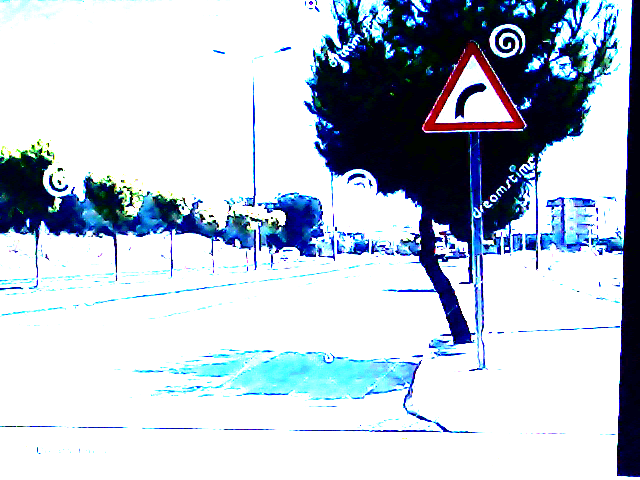

In [22]:
import cv2
from PIL import Image 
from PIL import ImageEnhance
from PIL import ImageOps

cap = cv2.VideoCapture(0) 
_ , cv2_im = cap.read()

cv2_im = cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
img = Image.fromarray(cv2_im)

bright = ImageEnhance.Brightness(img)                                     
img1 = bright.enhance(5.5)  

img1.save("numpy_altered_sample2.png")

image_file = "/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/numpy_altered_sample2.png"
im = Image.open(image_file)
display(im)

## 3. Classifying the captured images 
The images that were captured would be scan to detect and bounder the traffic sign, and classify them to notify the user

In [23]:
#### Measuring the bounders of the image and construct squares 
from PIL import ImageDraw
import statistics
imagess = []
bounds = []
for s in [64,96]:
    stride = s // 4
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                imagess.append(c)
                bounds.append(bound)
                



## 4. Launching BNN in hardware
The images are passed in the PL and the inference is performed. The images will be automatically formatted to the required format that is processed by CNV network (Cifar-10 format).

In [24]:
results2 = classifier.classify_images(imagess)         #classifying and predicting the captured image

Inference took 437705.00 microseconds, 329.10 usec per image
Classification rate: 3038.58 images per second


[ 178  580 1028]
[179]
[]
[ 168 1027 1048]
[1002 1003 1025 1026]
[]
[247]
[]
[  67 1049]
[30]
[169 206]
[]
Identified class name: Bend to right


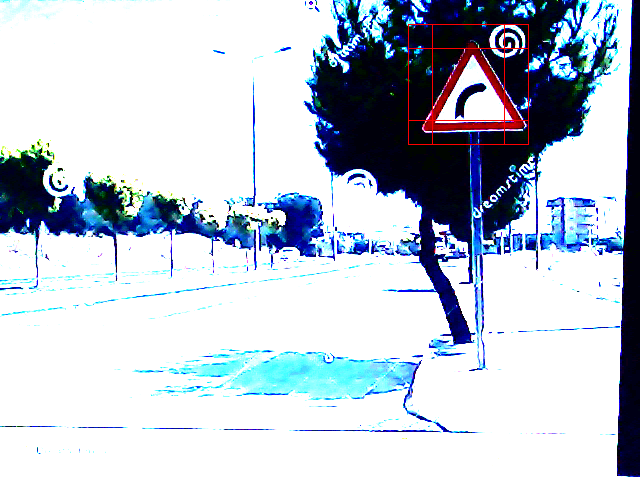

In [25]:
## The traffic sign in the images would be bounded and classified the highest indicied sign would be choosen
maxind=0
Road_Class = 0
for indexes in results:
    stop = results2 == indexes
    indicies = []
    indicies = stop.nonzero()[0]
    print(indicies)
    if len(indicies)>0:
        if maxind < statistics.mean(indicies):
            maxind = statistics.mean(indicies)
            Road_Class = indexes
            mainindicies = indicies
im2 = Image.open(image_file)
draw2 = ImageDraw.Draw(im2)
for i in mainindicies:
    draw2.rectangle(bounds[i], outline='red')       

print("Identified class name: {0}".format((classifier.class_name(Road_Class))))
im2

## 5. Demonstrate the results on the PYNQ Hardware
the classified traffic sign would be notified to the user end phase 

In [27]:
#Variable definition
base = BaseOverlay("base.bit")
pAudio = base.audio
Delay1 = 0.5
Delay2 = 0.7
color = 0
rgbled_position = [4,5]
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

# Traffic_Sign = classifier.class_name(results[4]) #10left 12right

if (Road_Class > 0):
    Traffic_Sign = classifier.class_name(Road_Class)


while ((base.buttons[0].read()==0)):
    print("press start system")
    for led in base.leds:
        led.on()  
      

    print("Traffic_Sign")   

    ############ HDMI Video Functionality #####################
    if( base.switches[0].read() == 1 and base.switches[1].read() == 1):
        print("initiating hdmi")

        base.download()

        hdmi_in.configure(PIXEL_RGB)               
        hdmi_out.configure(hdmi_in.mode, PIXEL_RGB)

        hdmi_in.start()
        hdmi_out.start()

        hdmi_in.tie(hdmi_out)
        sleep(3)

        colorspace_in = base.video.hdmi_in.color_convert
        colorspace_out = base.video.hdmi_out.color_convert
        sleep(2)

        frame = hdmi_in.readframe()
        print("HDMI ready for video streaming and image processing")
        while( base.switches[0].read() == 1 and base.switches[1].read() == 1):
            if (base.buttons[3].read()==1):
                print("night vision")
                bgr2rgb = [1.3, 0, 0,
                           1.9, 0, 0, 
                           0.9, 0, 0,
                           0, 0, 0  ]

                colorspace_in.colorspace = bgr2rgb
                colorspace_out.colorspace = bgr2rgb

                colorspace_in.colorspace
            if (base.buttons[2].read()==1):
                print("YCbCr vision")
                hdmi_in.colorspace = COLOR_IN_YCBCR
                sleep(1)
                hdmi_out.colorspace = COLOR_OUT_YCBCR

                frame = hdmi_in.readframe()
                image = Image.fromarray(frame, "YCbCr")
                frame.freebuffer()
                image.convert("RGB")

            if (base.buttons[1].read()==1):
                print("gray vision")
                bgr2rgb = [1, 0, 0,
                           1, 0, 0, 
                           1, 0, 0,
                           0, 0, 0  ]

                colorspace_in.colorspace = bgr2rgb
                colorspace_out.colorspace = bgr2rgb


                colorspace_in.colorspace

            if (base.buttons[1].read()==1):
                print("gray vision")
                bgr2rgb = [1, 0, 0,
                           1, 0, 0, 
                           1, 0, 0,
                           0, 0, 0  ]

                colorspace_in.colorspace = bgr2rgb
                colorspace_out.colorspace = bgr2rgb


                colorspace_in.colorspace

    hdmi_out.close()
    hdmi_in.close()

    ############ Periferal interaction with the classified sign #####################
    #Yellow LED flickering
    if (Traffic_Sign == 'Pedestrians in road ahead'):
        color = 6  
        i=0

        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/Pedestrians_in_road_ahead.pdm")
            pAudio.play()

        while (i<5):
            for led in rgbled_position:
                base.rgbleds[led].write(color)
                base.rgbleds[led].write(color)
            sleep(Delay1)
            for led in rgbled_position:
                base.rgbleds[led].off()
                base.rgbleds[led].off()
            sleep(Delay1)
            i=i+1

    # Yellow and White flickering LEDs For Road Works
    elif (Traffic_Sign == 'Road works'):    
        i=0
        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/Road_works.pdm")
            pAudio.play()

        while (i<2):
            for c in range(6):
                if (c%2):
                    base.rgbleds[4].write(2)
                    base.rgbleds[5].off()
                    sleep(Delay1)
                else:
                    base.rgbleds[5].write(7)
                    base.rgbleds[4].off()            
                    sleep(Delay1)
                c=c+1
            i=i+1   

    #Red and Blue Flickering LEDs for No Overstaking
    elif (Traffic_Sign == 'End of no-overtaking zone'):
        i=0
        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/no_overtaking.pdm")
            pAudio.play()
        while (i<2):
            for c in range(6):
                if (c%2):
                    base.rgbleds[4].write(4)
                    base.rgbleds[5].off()
                    sleep(Delay1)
                else:
                    base.rgbleds[5].write(1)
                    base.rgbleds[4].off()            
                    sleep(Delay1)
                c=c+1
            i=i+1 

    #Toggling 4 LEDs with slow Speed
    elif (Traffic_Sign == '30 Km/h'):
        i=0
        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/30km.pdm")
            pAudio.play()

        while (i<5):
            for led in (base.leds):
                led.off()
            sleep(1.5)
            for led in (base.leds):
                led.on()
            sleep(1.5)
        i=i+1

    #Toggling 4 LEDs with medium Speed
    elif (Traffic_Sign == '60 Km/h'):
        i=0
        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/60km.pdm")
            pAudio.play()

        while (i<5):
            for led in (base.leds):
                led.off()
            sleep(1)
            for led in (base.leds):
                led.on()
            sleep(1)
        i=i+1

    #Toggling 4 LEDs with Fast Speed
    elif (Traffic_Sign == '100 Km/h'):
        i=0
                #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/100km.pdm")
            pAudio.play()
        while (i<5):
            for led in (base.leds):
                led.off()
            sleep(0.5)
            for led in (base.leds):
                led.on()
            sleep(0.5)
        i=i+1

    #LEDs shift from left to right (LD3 -> LD0)
    elif (Traffic_Sign == 'Bend to right'):
        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/BendRIGHT.pdm")
            pAudio.play()

        print("right")
        for led in reversed(base.leds):
            led.off()
        sleep(Delay2)
        for led in reversed(base.leds):
            led.toggle()
            sleep(Delay2) 

        #LEDs shift from right to left (LD0 -> LD3)

    elif (Traffic_Sign == 'Bend to left'):
        print("right")

        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/BendLEFT.pdm")
            pAudio.play()

        
        for led in (base.leds):
            led.off()
        sleep(Delay2)
        for led in (base.leds):
            led.toggle()
            sleep(Delay2) 

    #RED LEd will lit for Stop        
    elif (Traffic_Sign == 'Stop'):
        color = 4  
        i=0

        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/Stop.pdm")
            pAudio.play()

        while (i<5):
            for led in rgbled_position:
                base.rgbleds[led].write(color)
                base.rgbleds[led].write(color)
            sleep(Delay1)
            for led in rgbled_position:
                base.rgbleds[led].off()
                base.rgbleds[led].off()
            sleep(Delay1)
            i=i+1

    #Blue left LEd will lit for Pass by on left         
    elif (Traffic_Sign == 'Pass by on left'):

        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/Pass_left.pdm")
            pAudio.play()
        base.rgbleds[4].off()    
        base.rgbleds[5].write(1)
        sleep(Delay2)

    #Blue left LEd will lit for Pass by on right                          
    elif (Traffic_Sign == 'Pass by on right'):

        #Voice Command 
        if ( ( base.switches[0].read() == 0 and base.switches[1].read() == 1)):
            pAudio.load("/home/xilinx/jupyter_notebooks/BNN-PYNQ-master/notebooks/Pass_right.pdm")
            pAudio.play()

        base.rgbleds[4].write(1)
        base.rgbleds[5].off()
        sleep(Delay2)


print('End of this demo ...')
for led in base.leds:
    led.off()
for led in rgbled_position:
    base.rgbleds[led].off()

press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
right
press start system
Traffic_Sign
initiating hdmi


KeyboardInterrupt: 

In [10]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()